In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from sklearn.utils import class_weight

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions
from src.models import model_mine

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [3]:
(X_train, y_train), X_test, (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/30160 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 170846.62it/s]


In [4]:
X_train.shape, X_train.values.shape

((30160,), (30160,))

### Compute the classes weights because our dataset is largely unbalanced

In [40]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

### Create an embedding matrix for our vocabulary

In [18]:
emb_matrix, word_index = get_embeddings_and_word_index(embeddings_path, vocab)  # Unknown words: 1302

print(f'{1302 / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

8.83% of our vocabulary are unknown words to the embedding matrix


### Transforming our sequences of words to indexes

In [6]:
X_train = sequences_to_index(X_train, word_index, max_seq_len)
X_test = sequences_to_index(X_test, word_index, max_seq_len)

X_train.shape, X_test.shape

((30160, 163), (2755, 163))

In [29]:
y_train = to_categorical(y_train, 4)
(x_trn, y_trn), (x_val, y_val), (x_tst, y_tst) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')
print('validation_test set: ' + str(len(x_tst)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 24128 samples
validation set: 3016 samples
validation_test set: 3016 samples
x_train: (24128, 163)
y_train: (24128, 4)


### Training

In [26]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 163, 300)          197828100 
_________________________________________________________________
dropout_4 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48900)             0         
__________

In [30]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=3)

Train on 24128 samples, validate on 3016 samples
Epoch 1/3
24128/24128 [==============================] - 412s 17ms/step - loss: 0.7389 - acc: 0.7119 - val_loss: 0.5311 - val_acc: 0.8054
Epoch 2/3
24128/24128 [==============================] - 411s 17ms/step - loss: 0.5073 - acc: 0.8153 - val_loss: 0.4098 - val_acc: 0.8525
Epoch 3/3
24128/24128 [==============================] - 402s 17ms/step - loss: 0.4122 - acc: 0.8506 - val_loss: 0.3653 - val_acc: 0.8644


### Evaluating our model

#### Validation set

True Positives per class :  [ 471.  349.  466. 1321.]
False Positives per class :  [ 82.  56.  81. 190.]
False Negatives per class :  [107.  74.  73. 155.]

Class angry : Precision : 0.852, Recall : 0.815, F1 : 0.833
Class happy : Precision : 0.862, Recall : 0.825, F1 : 0.843
Class sad : Precision : 0.852, Recall : 0.865, F1 : 0.858

Ignoring the Others class, Macro Precision : 0.8551, Macro Recall : 0.8348, Macro F1 : 0.8449
Ignoring the Others class, Micro TP : 1286, FP : 219, FN : 254

Accuracy : 0.8644, Micro Precision : 0.8545, Micro Recall : 0.8351, Micro F1 : 0.8447


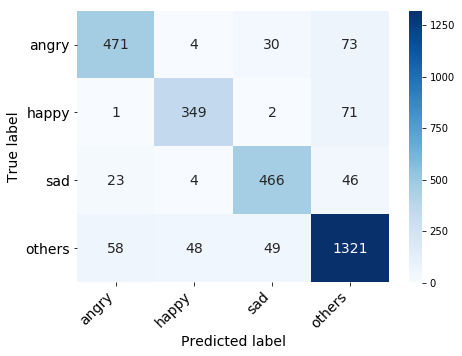

In [84]:
y_pred_val = get_predictions(model, x_val, y_val)

#### Test set

True Positives per class :  [ 470.  339.  507. 1347.]
False Positives per class :  [ 66.  57.  55. 175.]
False Negatives per class :  [ 81.  68.  73. 131.]

Class angry : Precision : 0.877, Recall : 0.853, F1 : 0.865
Class happy : Precision : 0.856, Recall : 0.833, F1 : 0.844
Class sad : Precision : 0.902, Recall : 0.874, F1 : 0.888

Ignoring the Others class, Macro Precision : 0.8784, Macro Recall : 0.8534, Macro F1 : 0.8657
Ignoring the Others class, Micro TP : 1316, FP : 178, FN : 222

Accuracy : 0.8830, Micro Precision : 0.8809, Micro Recall : 0.8557, Micro F1 : 0.8681


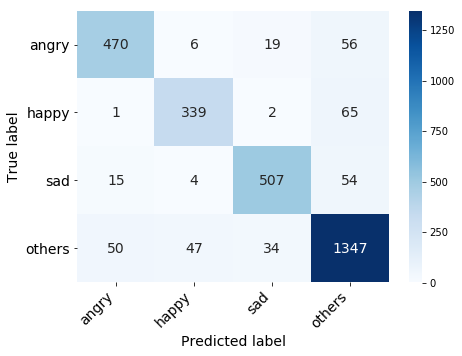

In [83]:
y_pred_tst = get_predictions(model, x_tst, y_tst)

In [85]:
model.save('pickles/models/tst_acc_0.88-tst_f1_0.868.h5')

In [90]:
word_index['<eos>']

KeyError: '<eos>'

In [92]:
'<eos>' in vocab

True